In [1]:
!pip install icecream
!pip install scikit-learn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import missingno as msno

In [2]:
import pandas as pd
from icecream import ic

try:
    income_df = pd.read_csv('dataset/income.csv')
    ic('Dataset loaded successfully')
except Exception as e:
    ic(f'Error loading dataset: {e}')

ic| 'Dataset loaded successfully'


In [3]:
# Display the shape of the DataFrame
print(f'Shape : {income_df.shape}')

# Display important information about the DataFrame
print(income_df.info())

Shape : (48842, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
None


In [4]:
# Display the first 5 values of income.csv
print(income_df.head())
print('--------------------------------------------------------------------------------')

# Display the last 5 values of income.csv
print(income_df.tail())

   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-per-week native-country incom

### Step 1 : Preprocessing the Data

In [5]:
# Check for duplicates in the DataFrame
duplicates = income_df.duplicated().sum()
print(f'Number of duplicates : {duplicates}')

# Drop duplicates from the DataFrame
income_df = income_df.drop_duplicates().reset_index(drop=True)

print(f"The number of duplicates has been removed. The new shape of the DataFrame is: {income_df.shape}")

Number of duplicates : 52
The number of duplicates has been removed. The new shape of the DataFrame is: (48790, 15)


In [6]:
# Display the number of missing values in each column
print("Missing Values\n-----------------------")
print((income_df.isin(['?'])).sum())

Missing Values
-----------------------
age                   0
workclass          2795
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2805
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      856
income                0
dtype: int64


#### 1.1 Handling missing values

In [7]:
# Replace '?' with NaN for data visualization and future imputation purposes
income_missing_df = income_df.replace('?',np.nan)

<Axes: >

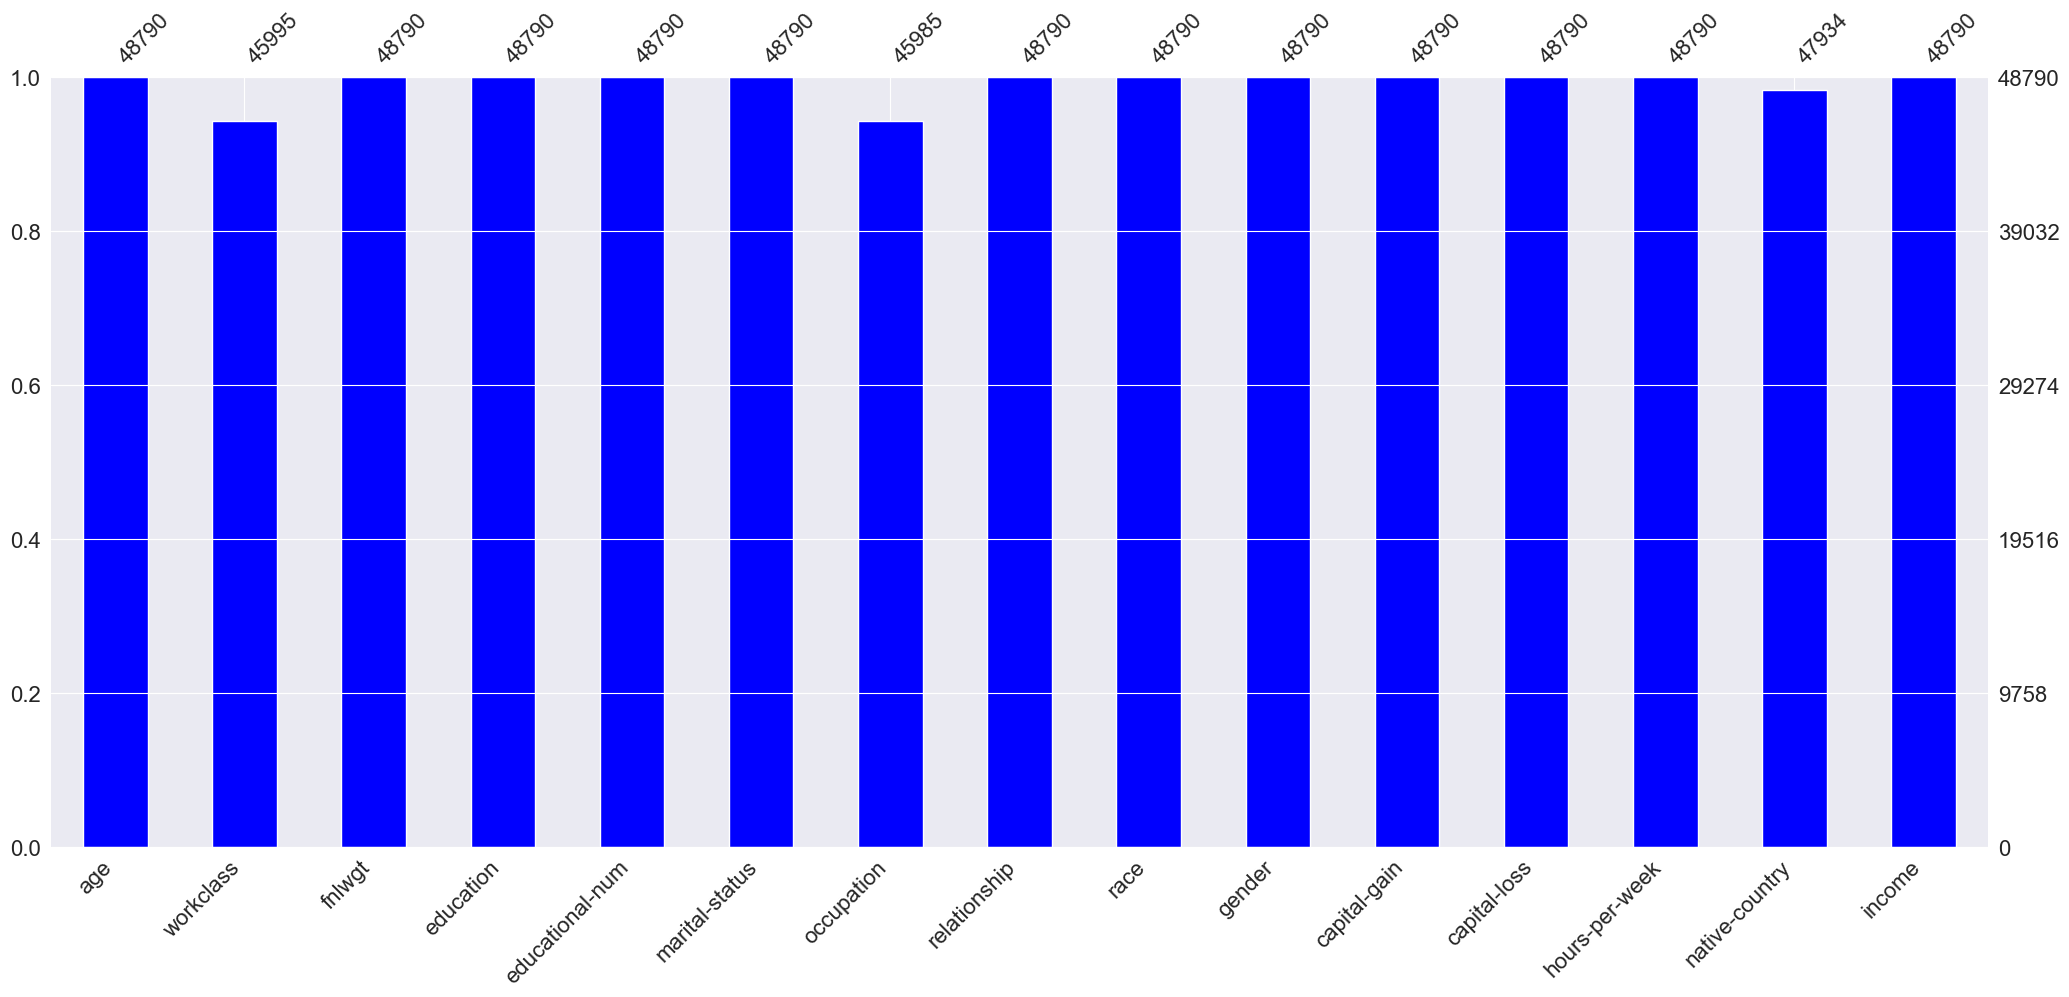

In [8]:
msno.bar(income_missing_df, color='blue')

<Axes: >

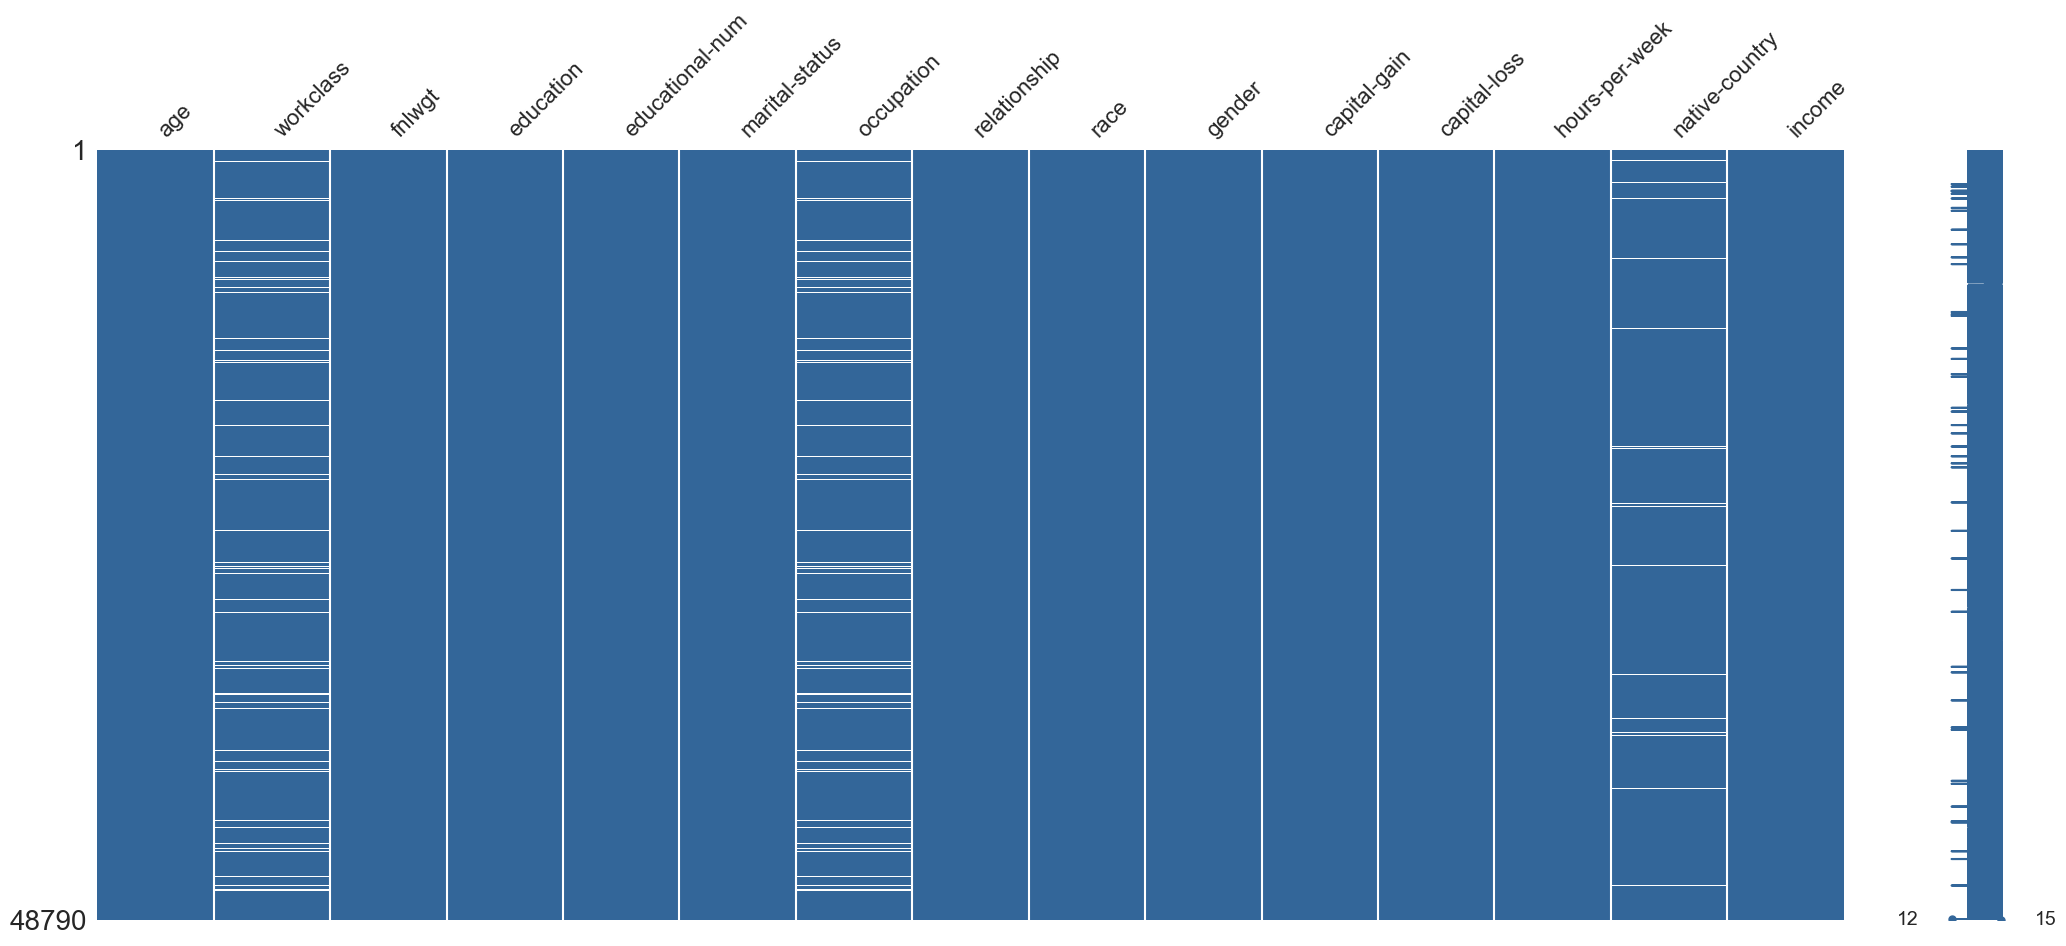

In [9]:
# Visualize the missing values in the DataFrame, and the correlation between the columns
msno.matrix(income_missing_df, color=(0.2, 0.4, 0.6))

#### Commentary
According to the bar chart above, the columns 'workclass', 'native-country', and 'occupation' have a significant number of missing values. The cooccurrence of the missing values in the 'workclass' and 'occupation' columns suggests that these two columns are related. This means that when the 'workclass' is missing, the 'occupation' is also likely to be missing, and vice versa. The 'native-country' column also has a significant number of missing values, but it does not appear to be correlated with the other two columns, as the missing values of this column seem to be randomly distributed across the dataset. The barchart sample of 200 rows displayed below helps to visualize the missing values more clearly. Indeed, it allows for a better understanding of how missing values are distributed in the dataset, and also helps to observe the point made previously

<Axes: >

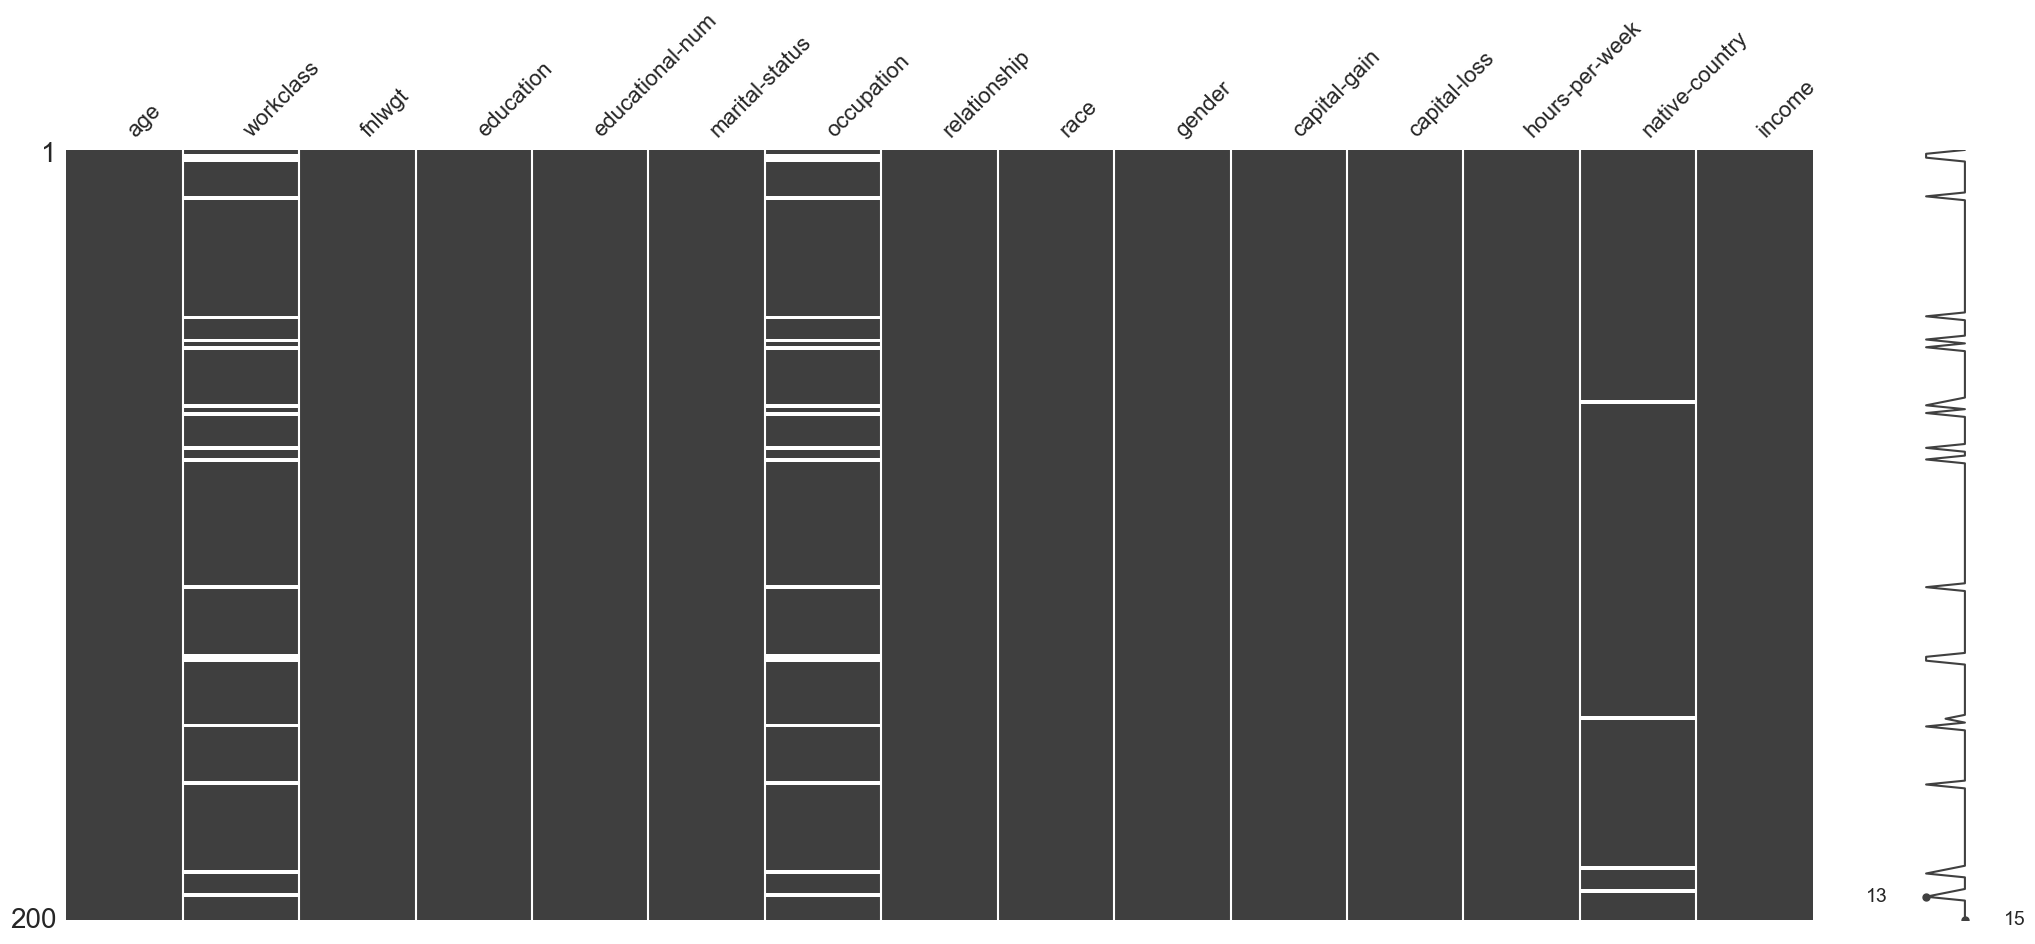

In [10]:
# Display a sample of 200 rows to visualize the missing values
msno.matrix(income_missing_df.sample(200))

In [11]:
missing_values_workclass = income_df[income_df['workclass'] == '?']['workclass'].count()/income_df['workclass'].count()

print(f'{round(missing_values_workclass * 100, 2)}% of the values of "workclass" are missing.')

missing_values_country = income_df[income_df['native-country'] == '?']['native-country'].count()/income_df['native-country'].count()

print(f'{round(missing_values_country * 100, 2)}% of the values of "native-country" are missing.')

missing_values_occupation = income_df[income_df['occupation'] == '?']['occupation'].count()/income_df['occupation'].count()

print(f'{round(missing_values_occupation * 100, 2)}% of the values of "occupation" are missing.')

5.73% of the values of "workclass" are missing.
1.75% of the values of "native-country" are missing.
5.75% of the values of "occupation" are missing.


<Axes: >

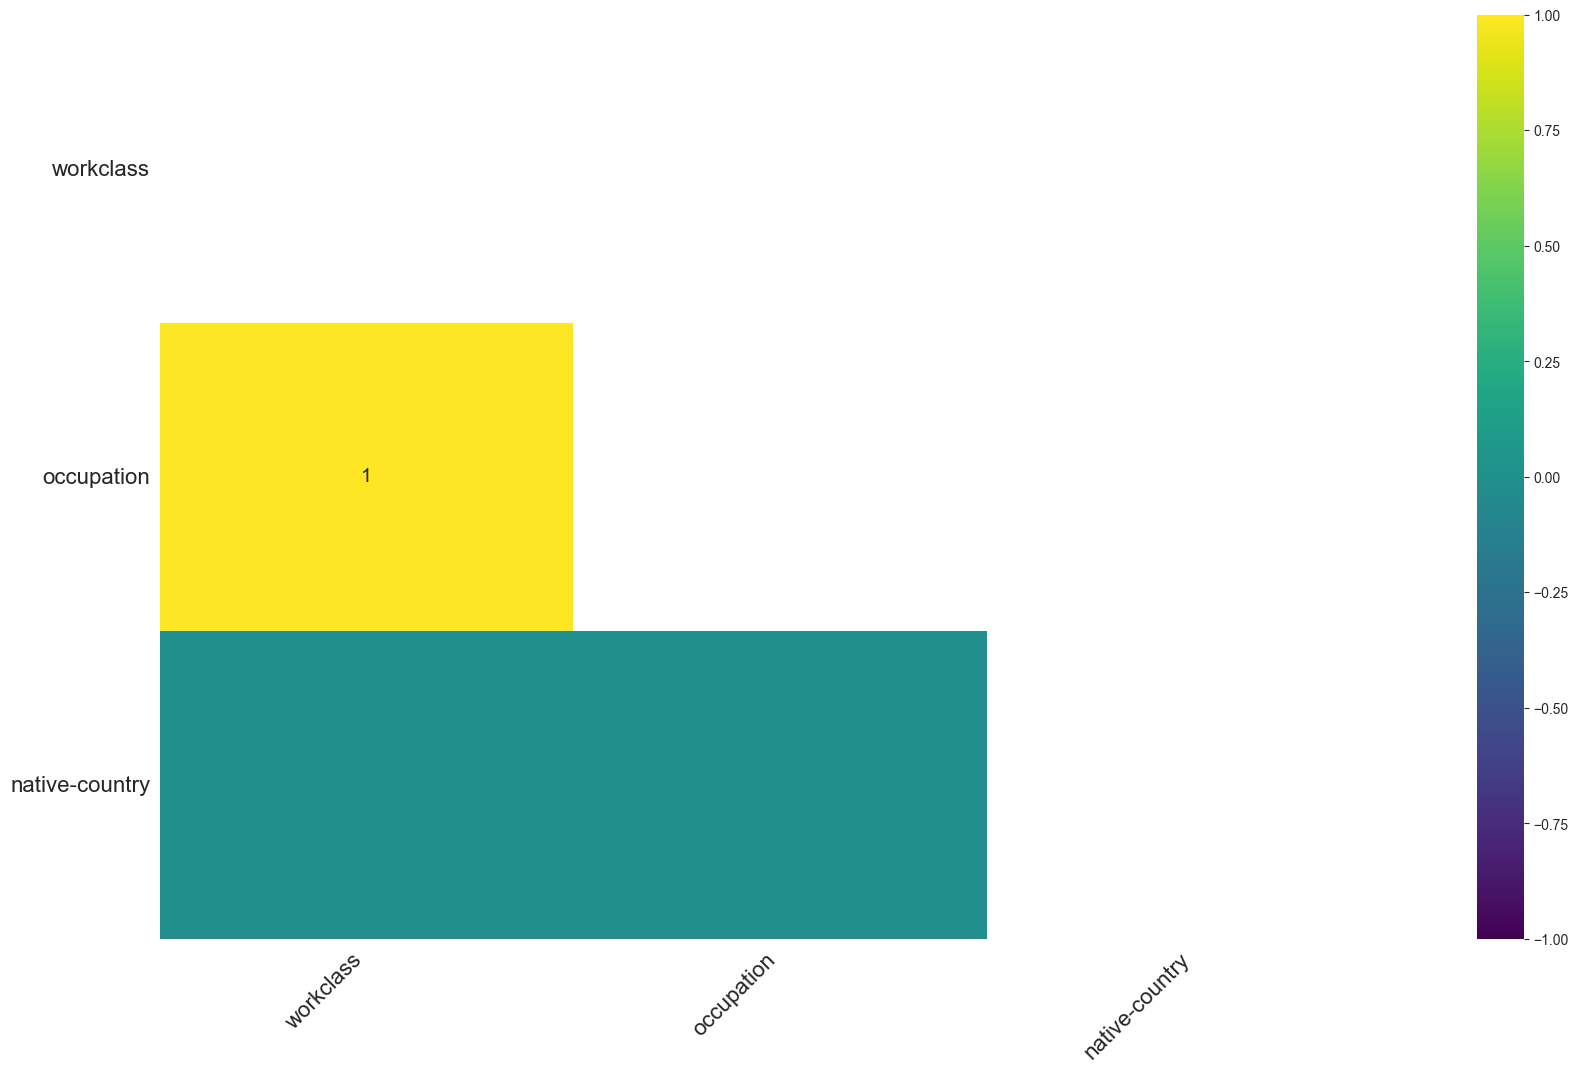

In [12]:
msno.heatmap(income_missing_df, cmap='viridis')

#### Commentary
The missing values in both the 'workclass' and 'occupation' columns appear to be highly correlated. Indeed, the following heatmap demonstrates a perfect and positive correlation between these two columns. This information indicates that there is a relationship between their missing values. We can therefore infer that in cases when an individual's employment class is unknown, their occupation may also be unknown. Thus, the missing values are non-random, which led us to introduce a new category called 'unknown' to impute those values.

In [13]:
missing_values_columns = ['workclass', 'native-country', 'occupation']

for col in missing_values_columns:
    print(f'The different values that can be taken by the column {col} : {income_df[col].unique()}\n')

The different values that can be taken by the column workclass : ['Private' 'Local-gov' '?' 'Self-emp-not-inc' 'Federal-gov' 'State-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked']

The different values that can be taken by the column native-country : ['United-States' '?' 'Peru' 'Guatemala' 'Mexico' 'Dominican-Republic'
 'Ireland' 'Germany' 'Philippines' 'Thailand' 'Haiti' 'El-Salvador'
 'Puerto-Rico' 'Vietnam' 'South' 'Columbia' 'Japan' 'India' 'Cambodia'
 'Poland' 'Laos' 'England' 'Cuba' 'Taiwan' 'Italy' 'Canada' 'Portugal'
 'China' 'Nicaragua' 'Honduras' 'Iran' 'Scotland' 'Jamaica' 'Ecuador'
 'Yugoslavia' 'Hungary' 'Hong' 'Greece' 'Trinadad&Tobago'
 'Outlying-US(Guam-USVI-etc)' 'France' 'Holand-Netherlands']

The different values that can be taken by the column occupation : ['Machine-op-inspct' 'Farming-fishing' 'Protective-serv' '?'
 'Other-service' 'Prof-specialty' 'Craft-repair' 'Adm-clerical'
 'Exec-managerial' 'Tech-support' 'Sales' 'Priv-house-serv'
 'Transport-moving' 'Hand

In [14]:
mode_value_workclass = income_df['workclass'].mode().iloc[0]
mode_value_country = income_df['native-country'].mode().iloc[0]
mode_value_occ = income_df['occupation'].mode().iloc[0]

print(f"The frequency of the mode in the column 'workclass' is {round(income_df[income_df['workclass'] == mode_value_workclass]['workclass'].count() / income_df['workclass'].count() * 100, 2)}%.")

print(f"The frequency of the mode in the column 'native-country' is {round(income_df[income_df['native-country'] == mode_value_country]['native-country'].count() / income_df['native-country'].count() * 100, 2)}%.")

print(f"The frequency of the mode in the column 'occupation' is {round(income_df[income_df['occupation'] == mode_value_occ]['occupation'].count() / income_df['occupation'].count() * 100, 2)}%.")

The frequency of the mode in the column 'workclass' is 69.4%.
The frequency of the mode in the column 'native-country' is 89.76%.
The frequency of the mode in the column 'occupation' is 12.64%.


In [15]:
# Before imputing the missing values in the 'workclass' column, check the second most frequent value in the column native-country
second_highest = income_df['native-country'].value_counts().index[1]

percentage = (income_df['native-country'][income_df['native-country'] == second_highest].count() / income_df['native-country'].count()) * 100

# We look for the second most frequent value in the column 'native-country' to check if it should be imputed with the mode value or not, or if it should be imputed with a new class 'unknown'
print(f'The value with the second highest frequency in the column "native-country" is "{second_highest}" with a frequency of {round(percentage,2)}%.')

The value with the second highest frequency in the column "native-country" is "Mexico" with a frequency of 1.93%.


In [16]:
print('Before\n--------------------------------------------------')
print(income_df['native-country'].head(20))

# Impute the missing values in the 'workclass' column with a new Unknown class
income_df['native-country'] = income_df['native-country'].apply(lambda x: 'Unknown' if x == '?' else x)
print('After\n--------------------------------------------------')
print(income_df['native-country'].head(20))

Before
--------------------------------------------------
0     United-States
1     United-States
2     United-States
3     United-States
4     United-States
5     United-States
6     United-States
7     United-States
8     United-States
9     United-States
10    United-States
11    United-States
12    United-States
13    United-States
14    United-States
15    United-States
16    United-States
17    United-States
18    United-States
19                ?
Name: native-country, dtype: object
After
--------------------------------------------------
0     United-States
1     United-States
2     United-States
3     United-States
4     United-States
5     United-States
6     United-States
7     United-States
8     United-States
9     United-States
10    United-States
11    United-States
12    United-States
13    United-States
14    United-States
15    United-States
16    United-States
17    United-States
18    United-States
19          Unknown
Name: native-country, dtype: object


#### Commentary

According to the previous heatmap, the native-country column appears to have randomly missing values. The mode in this column is dominant with a frequency of 89.76%, which indicates that the column is largely unbalanced. The most frequent variable after the mode, 'Mexico', accounts for 1.93% of the occurrences. Furthermore, 1.75% of the values in this column are missing, which is close to the previously mentioned proportion of 1.93%. Thus, the missing values are numerous enough to be treated as a separate category. Given these observations, we chose to impute with an arbitrary value 'unknown' to preserve the existing distribution and avoid reinforcing the already dominant mode. 

In [17]:
print('Before\n--------------------------------------------------')
print(income_df['workclass'].head(20))

income_df['workclass'] = income_df['workclass'].apply(lambda x: 'Unknown' if x == '?' else x)

print('After\n--------------------------------------------------')
print(income_df['workclass'].head(20))

Before
--------------------------------------------------
0              Private
1              Private
2            Local-gov
3              Private
4                    ?
5              Private
6                    ?
7     Self-emp-not-inc
8              Private
9              Private
10             Private
11         Federal-gov
12             Private
13                   ?
14             Private
15             Private
16           State-gov
17             Private
18             Private
19             Private
Name: workclass, dtype: object
After
--------------------------------------------------
0              Private
1              Private
2            Local-gov
3              Private
4              Unknown
5              Private
6              Unknown
7     Self-emp-not-inc
8              Private
9              Private
10             Private
11         Federal-gov
12             Private
13             Unknown
14             Private
15             Private
16           State-gov
17 

In [18]:
print('Before\n--------------------------------------------------')
print(income_df['occupation'].head(20))

income_df['occupation'] = income_df['occupation'].apply(lambda x: 'Unknown' if x == '?' else x)

print('After\n--------------------------------------------------')
print(income_df['occupation'].head(20))

Before
--------------------------------------------------
0     Machine-op-inspct
1       Farming-fishing
2       Protective-serv
3     Machine-op-inspct
4                     ?
5         Other-service
6                     ?
7        Prof-specialty
8         Other-service
9          Craft-repair
10    Machine-op-inspct
11         Adm-clerical
12         Adm-clerical
13                    ?
14    Machine-op-inspct
15      Exec-managerial
16        Other-service
17         Adm-clerical
18    Machine-op-inspct
19       Prof-specialty
Name: occupation, dtype: object
After
--------------------------------------------------
0     Machine-op-inspct
1       Farming-fishing
2       Protective-serv
3     Machine-op-inspct
4               Unknown
5         Other-service
6               Unknown
7        Prof-specialty
8         Other-service
9          Craft-repair
10    Machine-op-inspct
11         Adm-clerical
12         Adm-clerical
13              Unknown
14    Machine-op-inspct
15      Exec-

#### 1.2 Discretization of selected columns

**Hypothesis :** The columns "education" and "educational-num" refer to the same information

In [19]:
print(income_df['education'].head())
print('===================================================')
print(income_df['educational-num'].head())

0            11th
1         HS-grad
2      Assoc-acdm
3    Some-college
4    Some-college
Name: education, dtype: object
0     7
1     9
2    12
3    10
4    10
Name: educational-num, dtype: int64


In [20]:
print(income_df['education'].unique())
print('===================================================')
print(income_df['educational-num'].unique())

['11th' 'HS-grad' 'Assoc-acdm' 'Some-college' '10th' 'Prof-school'
 '7th-8th' 'Bachelors' 'Masters' 'Doctorate' '5th-6th' 'Assoc-voc' '9th'
 '12th' '1st-4th' 'Preschool']
[ 7  9 12 10  6 15  4 13 14 16  3 11  5  8  2  1]


In [21]:
# Create a dictionary to map education levels to ordinal variables.

education_dict = {
    'Preschool' : 1,
    '1st-4th':2,
    '5th-6th' : 3,
    '7th-8th' : 4,
    '9th' : 5,
    '10th' : 6,
    '11th' : 7,
    '12th' : 8,
    'HS-grad' : 9,
    'Some-college' : 10,
    'Assoc-voc' : 11,
    'Assoc-acdm' : 12,
    'Bachelors' : 13,
    'Masters' : 14,
    'Prof-school' : 15,
    'Doctorate' : 16
}

# Map the education levels to ordinal variables
income_df['education_mapped'] = income_df['education'].map(education_dict)

# Compute the correlation between the 'education' column and the 'educational-num' column
correlation = income_df['education'].map(education_dict).corr(income_df['educational-num'])

# Display the correlation
print(f'The correlation between the "education" and "educational-num" columns is {str(correlation)}.')

The correlation between the "education" and "educational-num" columns is 1.0.


#### Commentary
The correlation is perfect, linear, and positive. Thus, we can confirm that the "education" and "educational-num" columns refer to the same information. We can continue our preprocessing process. We will keep the "education" column and drop the "educational-num" column eventually.

In [22]:
def simplify_education(education):
    """
    Simplify the education level by grouping similar levels together.
    :param education: education level as a string
    :return: education level as a string
    """
    if education in ['1st-4th', 'Preschool']:
        return 'Elementary-school'
    elif education in ['5th-6th','7th-8th']:
        return  'Middle-school'
    elif education in ['9th', '10th', '11th', '12th']:
        return 'HS-no-diploma'
    else:
        return education

print('Before\n--------------------------------------------------')
print(income_df['education'].unique())

# Apply the function to the 'education' column to create a new column 'education-grouped'
income_df['education-grouped'] = income_df['education'].apply(lambda x: simplify_education(x))

print('After\n--------------------------------------------------')
print(income_df['education-grouped'].unique())

Before
--------------------------------------------------
['11th' 'HS-grad' 'Assoc-acdm' 'Some-college' '10th' 'Prof-school'
 '7th-8th' 'Bachelors' 'Masters' 'Doctorate' '5th-6th' 'Assoc-voc' '9th'
 '12th' '1st-4th' 'Preschool']
After
--------------------------------------------------
['HS-no-diploma' 'HS-grad' 'Assoc-acdm' 'Some-college' 'Prof-school'
 'Middle-school' 'Bachelors' 'Masters' 'Doctorate' 'Assoc-voc'
 'Elementary-school']


In [23]:
def simplify_working_hours(working_hours):
    """
    Simplify the working hours by grouping them into ranges.
    :param working_hours: working hours as a string
    :return: working hours as a string representing the range
    """
    working_hours = int(working_hours)
    if working_hours < 20:
        return '0–19'
    elif working_hours < 40:
        return '20–39'
    elif working_hours < 60:
        return '40–59'
    elif working_hours < 80:
        return '60–79'
    else:
        return '80+'


print('Before\n--------------------------------------------------')
print(income_df['hours-per-week'].unique())

income_df['hours-per-week-grouped'] = income_df['hours-per-week'].apply(lambda x: simplify_working_hours(x))


print('After\n--------------------------------------------------')
print(income_df['hours-per-week-grouped'].unique())


Before
--------------------------------------------------
[40 50 30 32 10 39 35 48 25 20 45 47  6 43 90 54 60 38 36 18 24 44 56 28
 16 41 22 55 14 33 37  8 12 70 15 75 52 84 42 80 68 99 65  5 17 72 53 29
 96 21 46  3  1 23 49 67 76  7  2 58 26 34  4 51 78 63 31 92 77 27 85 13
 19 98 62 66 57 11 86 59  9 64 73 61 88 79 89 74 69 87 97 94 82 91 81 95]
After
--------------------------------------------------
['40–59' '20–39' '0–19' '80+' '60–79']


#### Commentary
We decided to discretize the hours-per-week variable. First, this approach facilitates exploratory data analysis. Indeed, due to the variability of the values in this column, using its original format risks creating unnecessary noise. Whereas grouping them allows us to observe the relationships between working hours per week and other variables more clearly.

In [24]:
mode_value_capital_gain = income_df['capital-gain'].mode().iloc[0]

print(f"The frequency of the mode in the column 'capital-gain' is {round(income_df[income_df['capital-gain'] == mode_value_capital_gain]['capital-gain'].count() / income_df['capital-gain'].count() * 100, 2)}%.")

The frequency of the mode in the column 'capital-gain' is 91.73%.


In [25]:
print(f"There are {income_df['capital-gain'].nunique()} unique values in the 'capital-gain' columns.")
print("Before\n--------------------------------------------------")
print(income_df['capital-gain'].unique())

# Simplify the 'capital-gain' column to facilitate analysis
income_df['capital-gain-grouped'] = income_df['capital-gain'].apply(lambda x: 'Yes' if x > 0 else 'No')

print("After\n--------------------------------------------------")
print(income_df['capital-gain-grouped'].unique())

There are 123 unique values in the 'capital-gain' columns.
Before
--------------------------------------------------
[    0  7688  3103  6418  7298  3908 14084  5178 15024 99999  2597  2907
  4650  6497  1055  5013 27828  4934  4064  3674  2174 10605  3418   114
  2580  3411  4508  4386  8614 13550  6849  2463  3137  2885  2964  1471
 10566  2354  1424  1455  3325  4416 25236   594  2105  4787  2829   401
  4865  1264  1506 10520  3464  2653 20051  4101  1797  2407  3471  1086
  1848 14344  1151  2993  2290 15020  9386  2202  3818  2176  5455 11678
  7978  7262  6514 41310  3456  7430  2414  2062 34095  1831  6723  5060
 15831  2977  2346  3273  2329  9562  2635  4931  1731  6097   914  7896
  5556  1409  3781  3942  2538  3887 25124  7443  5721  1173  4687  6612
  6767  2961   991  2036  2936  2050  1111  2228 22040  3432  6360  2009
  1639 18481  2387]
After
--------------------------------------------------
['No' 'Yes']


#### Commentary
We decided to binarize the capital-gain variable to better assess its relevance in the dataset. This approach classifies respondents based on whether they received a capital gain or not. This decision was made following a few observations: the frequency of people who received no capital gain is 91.73%, and there is a large variability in the column, with 123 distinct classes. Therefore, the new variable capital_gain_grouped subdivides the original 'capital-gain' variable into two classes: 'Yes' and 'No'. 'Yes' indicates that the person received a capital gain, while 'No' means they did not.

In [26]:
mode_value_capital_loss = income_df['capital-loss'].mode().iloc[0]

print(f"The frequency of the mode in the column 'capital-loss' is {round(income_df[income_df['capital-loss'] == mode_value_capital_loss]['capital-loss'].count() / income_df['capital-loss'].count() * 100, 2)}%.")

The frequency of the mode in the column 'capital-loss' is 95.32%.


In [27]:
print(f"There are {income_df['capital-loss'].nunique()} different classes in the 'capital-loss' column.")

print("Before\n--------------------------------------------------")
print(income_df['capital-loss'].unique())

# Simplify the 'capital-loss' column to facilitate analysis
income_df['capital-loss-grouped'] = income_df['capital-loss'].apply(lambda x: 'Yes' if x > 0 else 'No')

print("Après\n--------------------------------------------------")
print(income_df['capital-loss-grouped'].unique())

There are 99 different classes in the 'capital-loss' column.
Before
--------------------------------------------------
[   0 1721 1876 2415 1887  625 1977 2057 1429 1590 1485 2051 2377 1672
 1628 1902 1602 1741 2444 1408 2001 2042 1740 1825 1848 1719 3004 2179
 1573 2205 1258 2339 1726 2258 1340 1504 2559 1668 1974 1980 1564 2547
 2002 1669 1617  323 3175 2472 2174 1579 2129 1510 1735 2282 1870 1411
 1911 1651 1092 1762 2457 2231 2238  653 1138 2246 2603 2392 1944 1380
 2465 1421 3770 1594  213 2149 2824 1844 2467 2163 1816 1648 2206 2352
  419 1539  880  810  974 4356 2489 1755 3683 2267 2080  155 3900 2201
 2754]
Après
--------------------------------------------------
['No' 'Yes']


#### Commentary
Just like the capital-gain variable, we discretized the capital-loss variable. Given its 99 distinct values and the fact that approximately 95.32% of respondents did not incur any capital loss, the variable was converted into a binary classification : Yes and No. More precisely, the 'Yes' class means that a person received a capital loss, while 'No' demonstrates the opposite.

In [28]:
def group_country(country):
    """
    Group countries into regions for better analysis.
    :param country: country name as a string
    :return: continent of which the country is a part
    """
    if country in ['United-States', 'Canada', 'Mexico']:
        return 'North America'

    elif country in ['Guatemala', 'Honduras', 'Nicaragua', 'El-Salvador',
                     'Cuba', 'Dominican-Republic', 'Haiti', 'Jamaica',
                     'Puerto-Rico', 'Trinadad&Tobago', 'Outlying-US(Guam-USVI-etc']:
        return 'Central America / Caribbean'

    elif country in ['Columbia', 'Ecuador', 'Peru']:
        return 'South America'

    elif country in ['Ireland', 'England', 'Scotland', 'Germany',
                     'France', 'Portugal', 'Italy', 'Greece', 'Poland',
                     'Hungary', 'Yugoslavia', 'Holand-Netherlands']:
        return 'Europe'

    elif country in ['Philippines', 'Vietnam', 'Thailand',
                     'Cambodia', 'Laos', 'Taiwan', 'China',
                     'Japan', 'India', 'Iran', 'Hong']:
        return 'Asia'
    elif country == 'Unknown':
        return country

    else:
        return 'Other'


print('Avant\n--------------------------------------------------')
print(income_df['native-country'].unique())

income_df['country-grouped'] = income_df['native-country'].apply(lambda x: group_country(x))

print('Après\n--------------------------------------------------')
print(income_df['country-grouped'].unique())

Avant
--------------------------------------------------
['United-States' 'Unknown' 'Peru' 'Guatemala' 'Mexico'
 'Dominican-Republic' 'Ireland' 'Germany' 'Philippines' 'Thailand' 'Haiti'
 'El-Salvador' 'Puerto-Rico' 'Vietnam' 'South' 'Columbia' 'Japan' 'India'
 'Cambodia' 'Poland' 'Laos' 'England' 'Cuba' 'Taiwan' 'Italy' 'Canada'
 'Portugal' 'China' 'Nicaragua' 'Honduras' 'Iran' 'Scotland' 'Jamaica'
 'Ecuador' 'Yugoslavia' 'Hungary' 'Hong' 'Greece' 'Trinadad&Tobago'
 'Outlying-US(Guam-USVI-etc)' 'France' 'Holand-Netherlands']
Après
--------------------------------------------------
['North America' 'Unknown' 'South America' 'Central America / Caribbean'
 'Europe' 'Asia' 'Other']


#### 1.3 Encoding categorical variables

In [29]:
# Drop the 'education' and 'native-country' columns, as they will be replaced by their grouped versions
df_encoding = income_df.drop(columns=['education', 'education-grouped', 'native-country', 'educational-num', 'capital-gain', 'capital-loss'])

In [30]:
# List of nominal columns to be encoded
categorical_variables = [
    'workclass',
    'occupation',
    'relationship',
    'race',
    'gender',
    'marital-status',
    'hours-per-week-grouped',
    'country-grouped',
    'capital-loss-grouped',
    'capital-gain-grouped',
    'income'
]

ohe_transformer = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_variables)
    ],
    remainder='passthrough'
)

# Fit and transform the DataFrame using OneHotEncoder
encoded_array = ohe_transformer.fit_transform(df_encoding)

# Create a new DataFrame with the encoded features
encoded_df = pd.DataFrame(
    encoded_array,
    columns=ohe_transformer.get_feature_names_out(),
    index=income_df.index,
    dtype=float
)

In [31]:
from sklearn.preprocessing import OrdinalEncoder

# Define the order of education levels for ordinal encoding
education_order = [
    'Elementary-school',
    'Middle-school',
    'HS-no-diploma',
    'HS-grad',
    'Some-college',
    'Assoc-voc',
    'Assoc-acdm',
    'Bachelors',
    'Masters',
    'Prof-school',
    'Doctorate'
]

# Create an OrdinalEncoder with the specified categories
edu_encoder = OrdinalEncoder(categories=[education_order])

# Fit and transform the 'education-grouped' column
income_df['education_encoded'] = edu_encoder.fit_transform(
    income_df[['education-grouped']]
)

In [32]:
encoded_df.columns

Index(['ohe__workclass_Federal-gov', 'ohe__workclass_Local-gov',
       'ohe__workclass_Never-worked', 'ohe__workclass_Private',
       'ohe__workclass_Self-emp-inc', 'ohe__workclass_Self-emp-not-inc',
       'ohe__workclass_State-gov', 'ohe__workclass_Unknown',
       'ohe__workclass_Without-pay', 'ohe__occupation_Adm-clerical',
       'ohe__occupation_Armed-Forces', 'ohe__occupation_Craft-repair',
       'ohe__occupation_Exec-managerial', 'ohe__occupation_Farming-fishing',
       'ohe__occupation_Handlers-cleaners',
       'ohe__occupation_Machine-op-inspct', 'ohe__occupation_Other-service',
       'ohe__occupation_Priv-house-serv', 'ohe__occupation_Prof-specialty',
       'ohe__occupation_Protective-serv', 'ohe__occupation_Sales',
       'ohe__occupation_Tech-support', 'ohe__occupation_Transport-moving',
       'ohe__occupation_Unknown', 'ohe__relationship_Husband',
       'ohe__relationship_Not-in-family', 'ohe__relationship_Other-relative',
       'ohe__relationship_Own-child', 'o

#### 1.4 Scaling numerical variables

In [33]:
# Scale the 'age' column using StandardScaler
scaler = StandardScaler()
print('Before\n-------')
print(income_df['age'].head())
income_df['age_norm'] = scaler.fit_transform(income_df[['age']])
print('After\n-------')
print(income_df['age_norm'].head())

Before
-------
0    25
1    38
2    28
3    44
4    18
Name: age, dtype: int64
After
-------
0   -0.995947
1   -0.047620
2   -0.777103
3    0.390069
4   -1.506585
Name: age_norm, dtype: float64


In [34]:
# Scale the 'fnlwgt' column using StandardScaler
print('Before\n-------')
print(income_df['fnlwgt'].head())
income_df['fnlwgt_norm'] = scaler.fit_transform(income_df[['fnlwgt']])
print('After\n-------')
print(income_df['fnlwgt_norm'].head())

Before
-------
0    226802
1     89814
2    336951
3    160323
4    103497
Name: fnlwgt, dtype: int64
After
-------
0    0.351584
1   -0.945452
2    1.394503
3   -0.277855
4   -0.815898
Name: fnlwgt_norm, dtype: float64


### Step 3 : Exploratory Data Analysis

#### 3.1 Workclass variable analysis

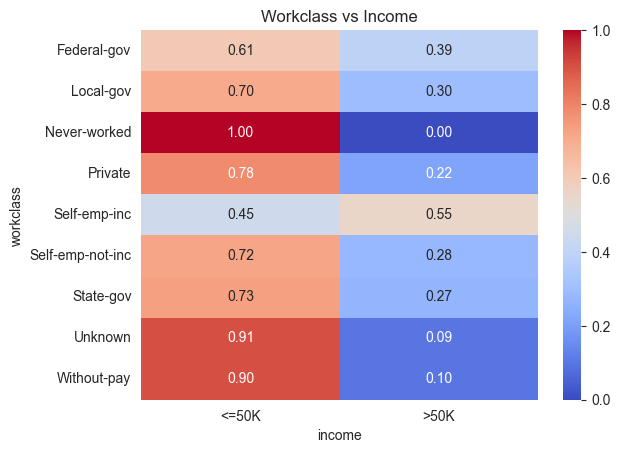

In [35]:
cross = pd.crosstab(income_df['workclass'], income_df['income'])
cross_percent = cross.div(cross.sum(axis=1), axis=0)
sns.heatmap(cross_percent, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Workclass vs Income")
plt.show()

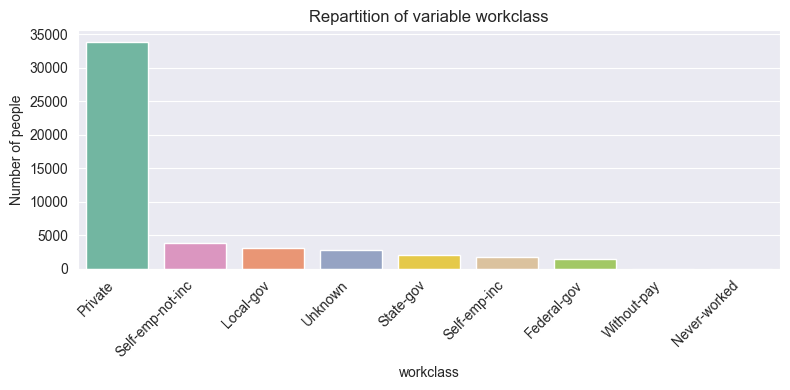

In [36]:
order = income_df['workclass'].value_counts().index

plt.figure(figsize=(8, 4))
sns.countplot(
    data=income_df,
    x='workclass',
    hue='workclass',
    order=order,
    palette="Set2",
    legend=False
)
plt.title(f"Repartition of variable workclass")
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of people')
plt.tight_layout()
plt.show()

#### Commentary

The heatmap above illustrates the repartition of the 'workclass' variable in relation to the 'income' variable.

First, as we already know, the majority of individuals in the dataset are employed in the private sector, accounting for 69.4% of the total. By contrast, 0.02% of individuals have never worked.

On the one hand, despite the dominant presence of private sector employees, according to the heatmap, only 22% of these individuals earn more than \\$50,000 per year. On the other hand, as expected, 90 % of people in the Never-worked category receive an income less than or equal to $50,000.

Interestingly enough, most of the respondents in the dataset, no matter the employment class, earn less than or equal to $ 50,000 per year. There seems to not be a strong correlation between the 'workclass' and 'income' variables, as the heatmap shows that the distribution of income is relatively similar across different work classes.

However, it is worth noting that the 'Self-emp-not-inc' and 'Federal-gov' work classes have a higher proportion of individuals earning more than \$50,000 compared to other work classes. This information is consistent with the standard. Self-employed workers are often advised to incorporate when they reach a high income level.

A key observation is the significant presence of the 'unknown' category in the workclass variable among individuals earning under \\$50,000. We had previously determined that there is a perfect and positive correlation between the 'unknown' category of the occupation variable and that of 'workclass'. Given this information, we can already predict that the unknown category of the occupation variable will itself also be present at 91% in the income class below \$50,000.




#### 3.2 Occupation variable analysis

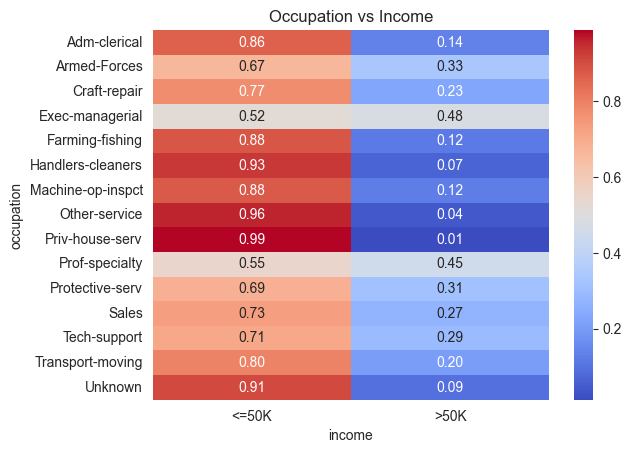

In [37]:
cross = pd.crosstab(income_df['occupation'], income_df['income'])
cross_percent = cross.div(cross.sum(axis=1), axis=0)
sns.heatmap(cross_percent, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Occupation vs Income")
plt.show()

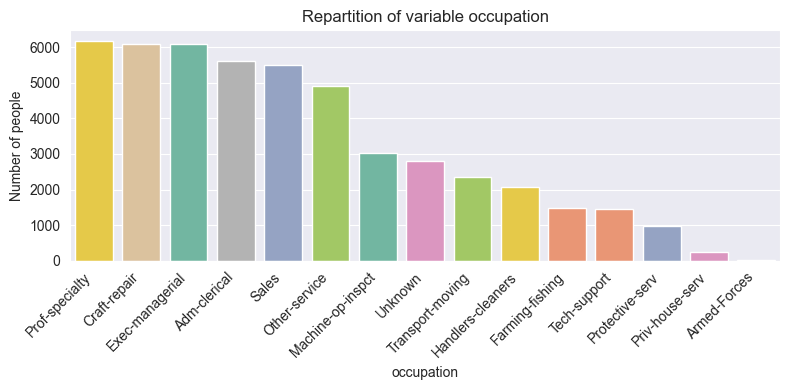

In [38]:
order = income_df['occupation'].value_counts().index

plt.figure(figsize=(8, 4))
sns.countplot(
    data=income_df,
    x='occupation',
    hue='occupation',
    order=order,
    palette="Set2",
    legend=False
)
plt.title(f"Repartition of variable occupation")
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of people')
plt.tight_layout()
plt.show()

#### Commentary
The barplot above shows there is a strong concentration around five main categories: Prof-specialty, Craft-repair, Exec-managerial, Adm-clerical, and Sales. These categories alone represent more than 64% of the total data. The most frequent profession is Prof-specialty, which includes approximately 6,000 individuals. At the opposite end, the Armed Forces profession is the least represented, with a negligible share of less than 1% of the sample.

The previous heatmap illustrates the repartition of the 'occupation' variable in relation to the 'income' variable. The "Exec-managerial" and "Prof-specialty" professions have the highest proportions of incomes above \\$50,000, with 48% and 45% respectively earning high incomes. This is consistent with the nature of these positions, which are often skilled and well-paid.

In contrast, occupations such as "Private-house-serv," "Handlers-cleaners," and "Other-service" show very low proportions of high incomes, below 10%. The "Private-house-serv" category is particularly extreme, with 99% of individuals earning \\$50,000 or less.

Another notable point concerns the "Unknown" category, which represents 91% of low incomes, which aligns with our previous hypothesis. This suggests that individuals in this category are likely to be underemployed or not employed at all, which is consistent with the low income level.

#### 3.3 Relationship variable analysis

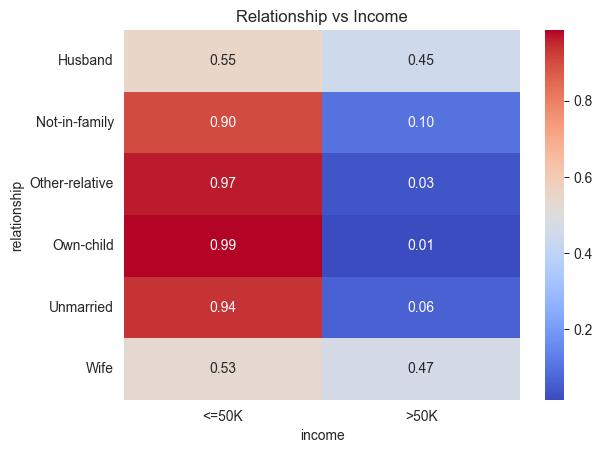

In [39]:
cross = pd.crosstab(income_df['relationship'], income_df['income'])
cross_percent = cross.div(cross.sum(axis=1), axis=0)
sns.heatmap(cross_percent, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Relationship vs Income")
plt.show()

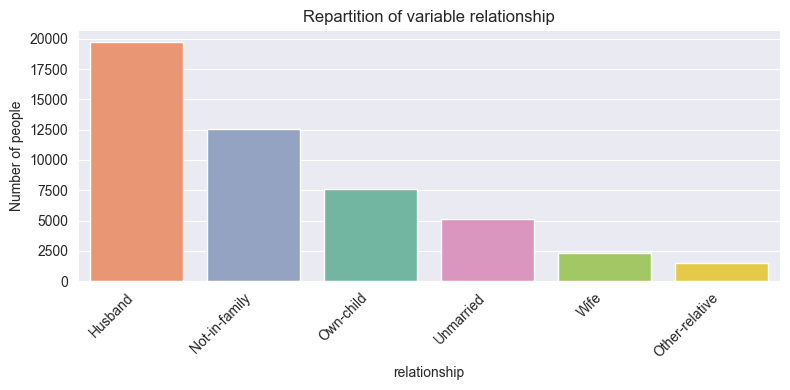

In [40]:
order = income_df['relationship'].value_counts().index

plt.figure(figsize=(8, 4))
sns.countplot(
    data=income_df,
    x='relationship',
    hue='relationship',
    order=order,
    palette="Set2",
    legend=False
)
plt.title(f"Repartition of variable relationship")
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of people')
plt.tight_layout()
plt.show()

#### Commentary
There is a clear predominance of the Husband category in the relationship column, which alone accounts for a significant proportion of individuals.

By cross-referencing the relationship variable with income level, the heatmap above reveals some interesting findings. First, the majority of individuals identified in the category "Own-child" have an income of \\$50,000 or less, with a rate exceeding 99%. Similar trends are observed for the "Other-relative" (97%) and "Unmarried" (94%) categories. The previous contrats suggest that these groups are primarily composed of dependent or economically marginalized individuals.

Conversely, the "Husband" and "Wife" categories are distinguished by a more balanced distribution. Respectively, 45% and 47% of these individuals have an income above \\$50,000, which is significantly higher compared to the other groups. These results may be explained by the fact that these individuals often occupy a central position in the household and benefit from greater professional or economic stability.

It is also worth noting that the "Not-in-family" category, while quite common in the sample, is strongly associated with lower incomes. Only 10% of people in this category exceed the \\$50,000 threshold, which may reflect increased precarity among people living alone or without a recognized family connection in the household.

#### 3.4 Race variable analysis

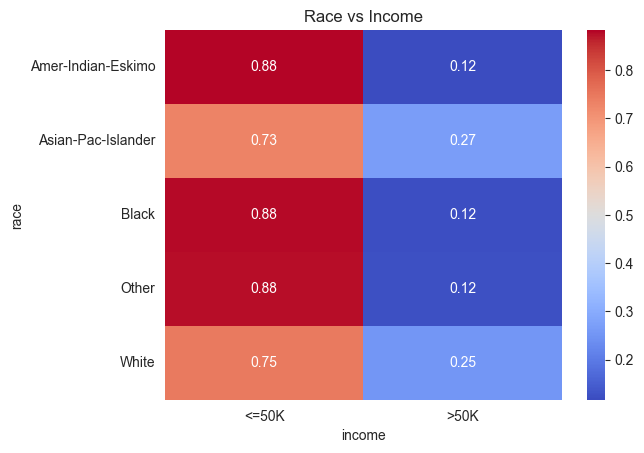

In [41]:
cross = pd.crosstab(income_df['race'], income_df['income'])
cross_percent = cross.div(cross.sum(axis=1), axis=0)
sns.heatmap(cross_percent, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Race vs Income")
plt.show()

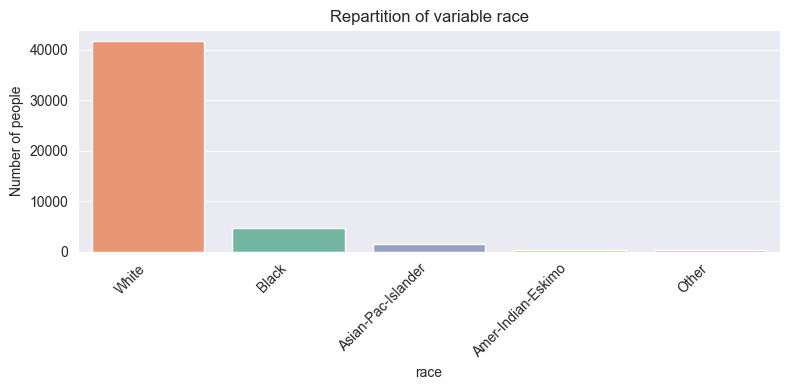

In [42]:
order = income_df['race'].value_counts().index

plt.figure(figsize=(8, 4))
sns.countplot(
    data=income_df,
    x='race',
    hue='race',
    order=order,
    palette="Set2",
    legend=False
)
plt.title(f"Repartition of variable race")
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of people')
plt.tight_layout()
plt.show()

#### Commentary
The count plot above illustrates the distribution of individuals by race variable. We can observe that there is a strong dominance of the White category, which represents the vast majority of respondents, with over 40,000 individuals. This category therefore constitutes the mode of the race variable. Other groups, including Black, Asian-Pacific Islander, American Indian-Eskimo, and Other, are significantly less represented. Indeed, together, these groups form a minority of the sample. The least frequent category is Other, which accounts for only a small percentage of observations, approximately 0.83% of the values.

The previous heatmap highlights the income proportions within each racial group. The results reveal significant differences. The "Asian-Pacific Islander" (27%) and "White" (25%) categories have the highest rates of incomes above \\$50,000. These results may be associated with gaps in access to skilled employment, education, or structural factors specific to the labor market.

Conversely, the "Black," "American-Indian-Eskimo," and "Other" categories show a very high concentration of incomes ≤$50,000, with 88% of individuals in these groups in this range. This may reflect persistent economic inequalities within the population, but these results should be interpreted with caution, particularly given the small sample sizes in some minority categories.

#### 3.5 Gender variable analysis

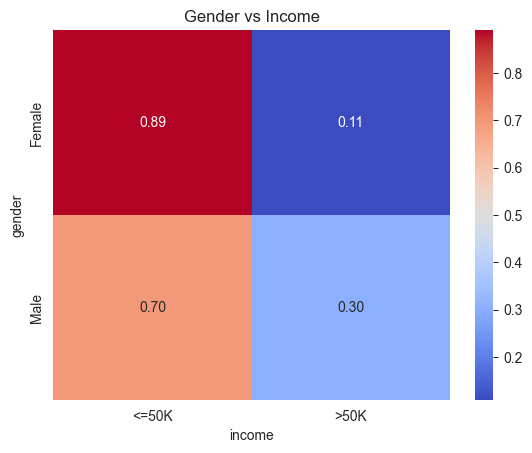

In [53]:
cross = pd.crosstab(income_df['gender'], income_df['income'])
cross_percent = cross.div(cross.sum(axis=1), axis=0)
sns.heatmap(cross_percent, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Gender vs Income")
plt.show()

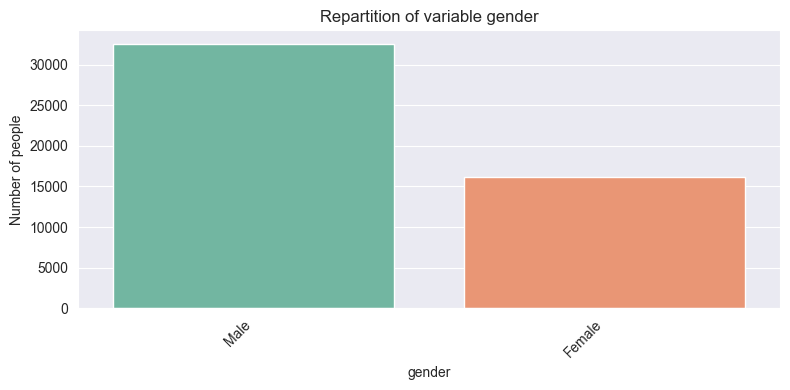

In [44]:
order = income_df['gender'].value_counts().index

plt.figure(figsize=(8, 4))
sns.countplot(
    data=income_df,
    x='gender',
    hue='gender',
    order=order,
    palette="Set2",
    legend=False
)
plt.title(f"Repartition of variable gender")
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of people')
plt.tight_layout()
plt.show()

#### Commentary
The count plot illustrates the distribution of individuals according to their gender. We observe a sample predominantly composed of men, with more than 32,000 individuals compared to approximately 16,000 women. The most frequent modality is therefore Male, which represents approximately 67% of the population studied. The Female category is, logically, the least frequent, with approximately one third of the observations.

The previous heatmap shows the distribution of income levels within each gender group. The differences are clear; 30% of men earn more than $50,000, while only 11% of women exceed this threshold.

These results highlight a clear income inequality between the sexes, with women significantly underrepresented in the highest income brackets. While this disparity may reflect multiple factors (access to leadership positions, differences in working hours, distribution of family roles, etc.), it remains an important element to consider in the analysis.

#### 3.5 Hours-per-week-grouped variable analysis

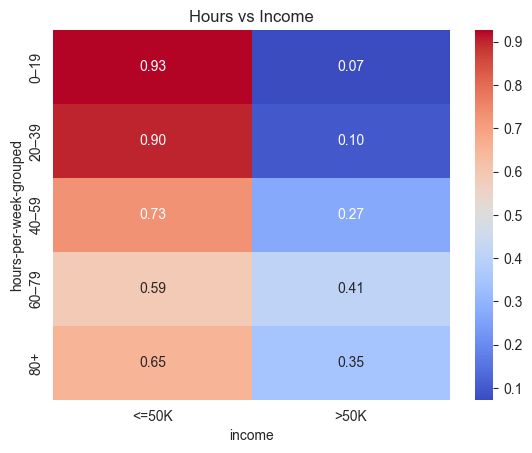

In [45]:
cross = pd.crosstab(income_df['hours-per-week-grouped'], income_df['income'])
cross_percent = cross.div(cross.sum(axis=1), axis=0)
sns.heatmap(cross_percent, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Hours vs Income")
plt.show()

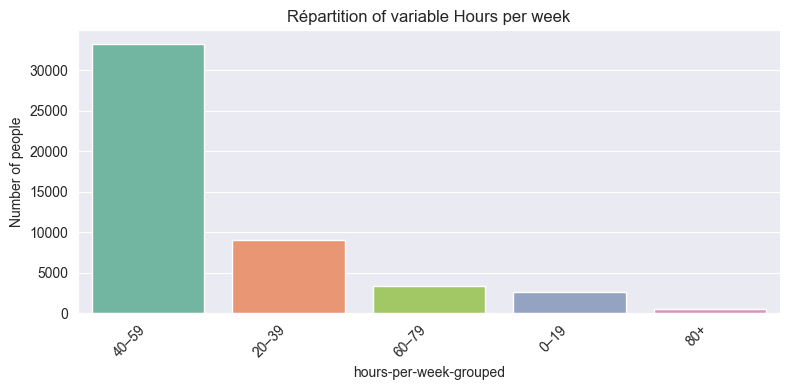

In [46]:
order = income_df['hours-per-week-grouped'].value_counts().index

plt.figure(figsize=(8, 4))
sns.countplot(
    data=income_df,
    x='hours-per-week-grouped',
    hue='hours-per-week-grouped',
    order=order,
    palette="Set2",
    legend=False
)
plt.title(f"Répartition of variable Hours per week")
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of people')
plt.tight_layout()
plt.show()

#### 3.6 Education-grouped variable analysis

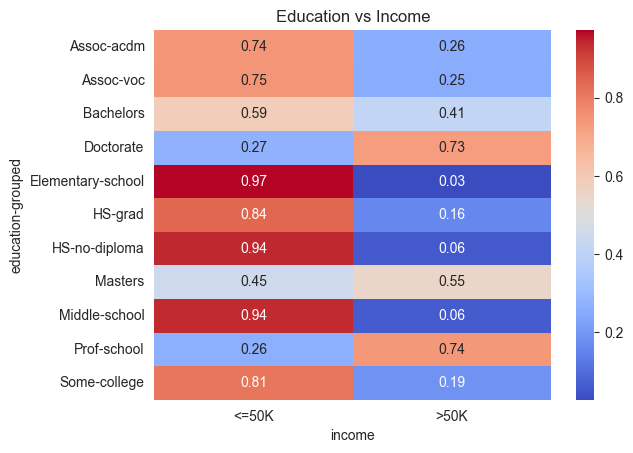

In [47]:
cross = pd.crosstab(income_df['education-grouped'], income_df['income'])
cross_percent = cross.div(cross.sum(axis=1), axis=0)
sns.heatmap(cross_percent, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Education vs Income")
plt.show()

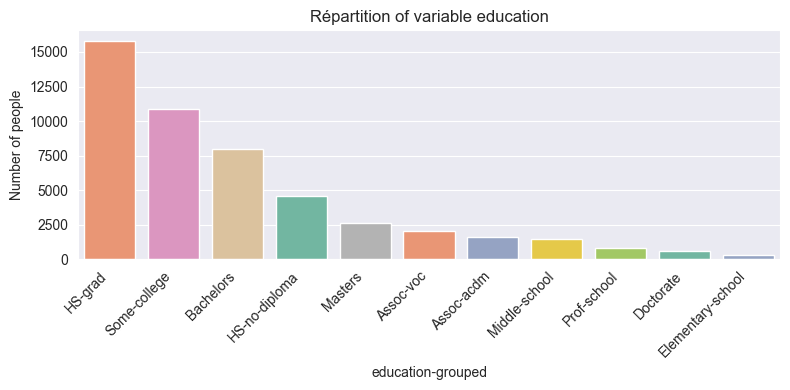

In [48]:
order = income_df['education-grouped'].value_counts().index

plt.figure(figsize=(8, 4))
sns.countplot(
    data=income_df,
    x='education-grouped',
    hue='education-grouped',
    order=order,
    palette="Set2",
    legend=False
)
plt.title(f"Répartition of variable education")
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of people')
plt.tight_layout()
plt.show()

#### 3.7 Income variable analysis

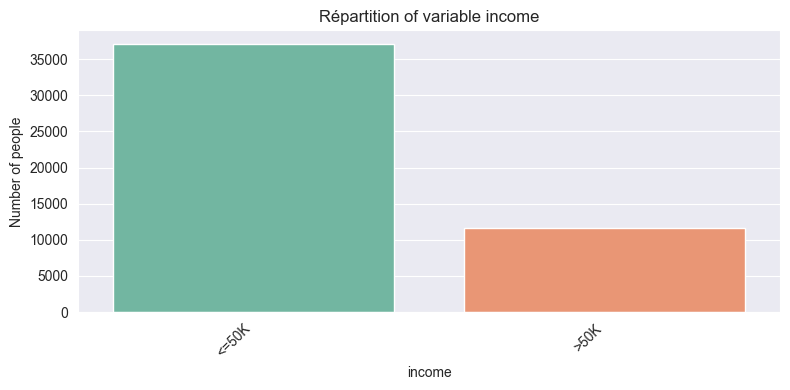

In [49]:
order = income_df['income'].value_counts().index

plt.figure(figsize=(8, 4))
sns.countplot(
    data=income_df,
    x='income',
    hue='income',
    order=order,
    palette="Set2",
    legend=False
)
plt.title(f"Répartition of variable income")
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of people')
plt.tight_layout()
plt.show()

#### 3.8 Capital-gain variable analysis

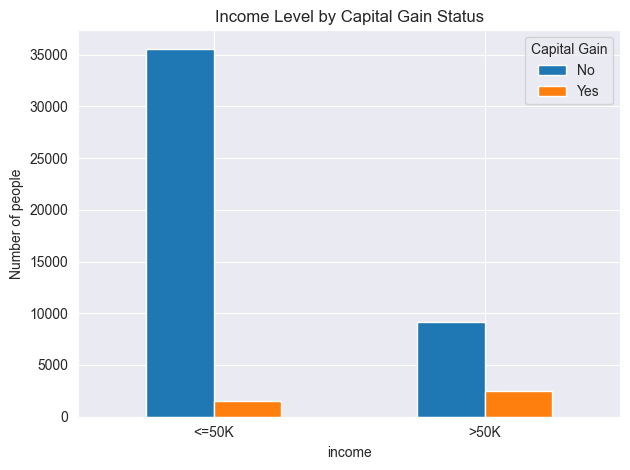

In [50]:
counts = income_df.groupby(['income', 'capital-gain-grouped']).size().unstack()

# Plot
counts.plot(kind='bar')

plt.ylabel('Number of people')
plt.title('Income Level by Capital Gain Status')
plt.xticks(rotation=0)
plt.legend(title='Capital Gain')
plt.tight_layout()
plt.show()

#### 3.9 Capital-loss variable analysis

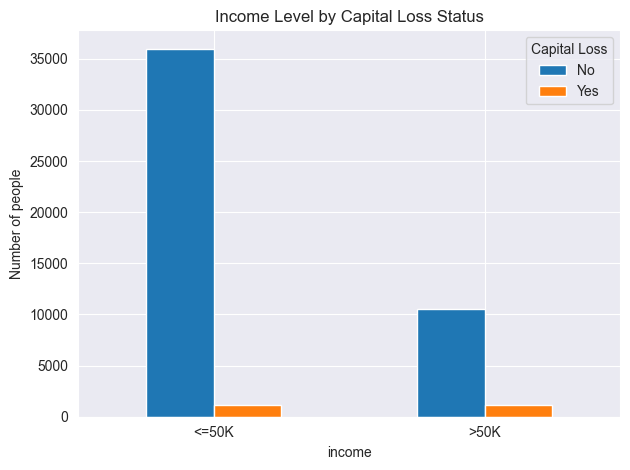

In [51]:
counts = income_df.groupby(['income', 'capital-loss-grouped']).size().unstack()

# Plot
counts.plot(kind='bar')

plt.ylabel('Number of people')
plt.title('Income Level by Capital Loss Status')
plt.xticks(rotation=0)
plt.legend(title='Capital Loss')
plt.tight_layout()
plt.show()
